# Testing Main Program

This notebook is mostly a copy of Main_program.py

Adrian 2020-03-26


# Warning: this notebook contains some outdated sections!

Peter 2020-05-06

### Imports

In [1]:
!pip install keras==2.1.6

     |################################| 348kB 2.8MB/s eta 0:00:01
You should consider upgrading via the 'pip install --upgrade pip' command.


In [5]:
import tensorflow
tensorflow.__version__

'1.8.0'

In [1]:
import os
if 'notebooks' in os.getcwd(): os.chdir('..')  # change to main directory
print('Current directory: {}'.format( os.getcwd() ))

import glob as glob
import scipy.io as sio
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
plt.style.use('seaborn-darkgrid')

import numpy as np
import scipy.io as sio
from scipy import optimize
from scipy.ndimage.filters import gaussian_filter
from scipy.signal import resample
from scipy.interpolate import interp1d

import os
from os.path import normpath, basename
import glob

import matplotlib.pyplot as plt

from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Flatten, MaxPooling1D, Conv1D, Input, LSTM,BatchNormalization, LocallyConnected1D, Activation, concatenate
from keras import backend as K


from helper_scripts.utils import define_model, noiselevels_test_dataset, preprocess_test_dataset
from helper_scripts.utils import preprocess_groundtruth_artificial_noise, calibrated_ground_truth_artificial_noise,preprocess_groundtruth_artificial_noise_balanced
from helper_scripts.utils_discrete_spikes import divide_and_conquer, fill_up_APs, systematic_exploration, prune_APs # random_motion


Current directory: /mapped/Calibrated-inference-of-spiking


Using TensorFlow backend.


### Set model configuration and parameters

In [2]:
# Smoothing of ground truth
smoothing = 0.2 # std of Gaussian smoothing in time (sec)

# Determines how the time window used as input is positioned around the actual time point
windowsize = 64 # 64 timepoints
before_frac, after_frac = 0.5, 0.5 # symmetric

# Set model parameters 
conv_filter = Conv1D
filter_sizes = (31, 19, 5) # for each conv layer
filter_numbers = (30,40,50) # for each conv layer
dense_expansion = 30 # for dense layer

# Set parameters of gradient descent learning
loss_function = 'mean_squared_error'
optimizer = 'Adagrad'
nr_of_epochs = 10

# Use ensemble learning
ensemble_size = 5

In [3]:
sampling_rate = 6    # 5-10% off

### Use test dataset & set sampling/imaging rate

In [4]:
test_dataset_folder = os.path.join('Example_datasets','Multiplane-OGB1-zf-pDp-Rupprecht-7.5Hz')
# sampling_rate = 7.5    # 5-10% off

### Extract noise level distribution for the test dataset

In [5]:
fileList = glob.glob( os.path.join( test_dataset_folder, '*.mat'))

noise_levels_all = [None] * len(fileList)
for file_index,file in enumerate(fileList):
  noise_levels_all[file_index] = noiselevels_test_dataset(file,before_frac,windowsize,after_frac,sampling_rate)

noise_levels_pooled = np.array(noise_levels_all)
noise_levels_pooled = noise_levels_pooled[~np.isnan(noise_levels_pooled)]

percent99 = np.percentile(noise_levels_pooled,99)
percent999 = np.percentile(noise_levels_pooled,99.9)
percent1 = np.percentile(noise_levels_pooled,1)

noise_levels_model = np.arange(2,np.ceil(percent99)+1)
nb_noise_levels = len(noise_levels_model)

/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:4033: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


### Plot distribution

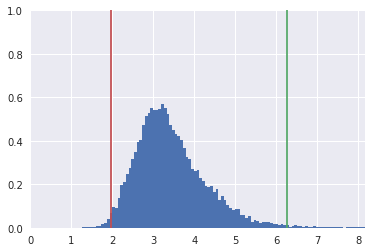

In [6]:
plt.figure()
plt.hist(noise_levels_pooled,density=True,bins=300)  # normed replaced with density: AttributeError: 'Rectangle' object has no property 'normed' (newer matplotlib version probably)
plt.plot([percent99, percent99],[0, 1])
plt.plot([percent1, percent1],[0, 1])
plt.ylim([0, 1])
_ = plt.xlim([0, percent999])

In [7]:
!nvidia-smi

Fri Apr  3 07:34:06 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 384.130                Driver Version: 384.130                   |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 106...  Off  | 00000000:01:00.0 Off |                  N/A |
| 24%   35C    P0    28W / 120W |    274MiB /  6072MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

### Train network(s)

In [8]:


# dataset_list = ['DS01-OGB1-m-V1',
#  'DS02-Cal520-m-S1',
#  'DS03-OGB1-zf-pDp',
#  'DS04-Cal520-zf-pDp',
#  'DS05-GCaMP6f-zf-aDp',
#  'DS06-GCaMP6f-zf-dD',
#  'DS07-GCaMP6f-zf-dD',
#  'DS08-GCaMP6f-m-V1',
#  'DS09-GCaMP6f-m-V1-neuropil-corrected',
#  'DS10-GCaMP6f-m-V1-neuropil-corrected',
#  'DS11-GCaMP6s-m-V1-neuropil-corrected',
#  'DS12-GCaMP6s-m-V1-neuropil-corrected',
#  'DS13-GCaMP6s-m-V1',
#  'DS14-GCaMP6s-m-V1',
#  'DS15-GCaMP6s-m-V1',
#  'DS16-GCaMP5k-m-V1',
#  'DS17-R-CaMP-m-CA3',
#  'DS18-R-CaMP-m-S1',
#  'DS19-jRCaMP1a-m-V1',
#  'DS20-jGECO1a-m-V1']



# GCamp6s
# dataset_list_good = ['DS11-GCaMP6s-m-V1-neuropil-corrected',
#  'DS12-GCaMP6s-m-V1-neuropil-corrected',
#  'DS13-GCaMP6s-m-V1',
#  'DS14-GCaMP6s-m-V1',
#  'DS15-GCaMP6s-m-V1']

# gcamp6f
# dataset_list_good = ['DS08-GCaMP6f-m-V1',
#  'DS09-GCaMP6f-m-V1-neuropil-corrected',
#  'DS10-GCaMP6f-m-V1-neuropil-corrected']
#


dataset_list_good = ['DS08-GCaMP6f-m-V1',
 'DS09-GCaMP6f-m-V1-neuropil-corrected',
 'DS10-GCaMP6f-m-V1-neuropil-corrected']




('GT_dataset_GC6f_Chen',)

In [9]:
noise_levels_model = np.arange(1,10)
nb_noise_levels = len(noise_levels_model)
noise_levels_model

array([1, 2, 3, 4, 5, 6, 7, 8, 9])

In [10]:
import time
start = time.time()

load_pretrained_models = 0 # load pre-trained models

# GCaMP6f
# datasets = [
#             'DS08-GCaMP6f-m-V1',
#             'DS09-GCaMP6f-m-V1-neuropil-corrected',
#             'DS10-GCaMP6f-m-V1-neuropil-corrected',
#            ]

# GCaMP6s
datasets = [
            'DS11-GCaMP6s-m-V1-neuropil-corrected',
            'DS12-GCaMP6s-m-V1-neuropil-corrected',
            'DS13-GCaMP6s-m-V1',
            'DS14-GCaMP6s-m-V1',
            'DS15-GCaMP6s-m-V1'
            ]

training_dataset_folders = [os.path.join('Ground_truth',dataset) for dataset in datasets]
print(training_dataset_folders)

set_of_models = [[None]*ensemble_size for _ in range(nb_noise_levels)] 

for noise_level_index,noise_level in enumerate(noise_levels_model):
    for ensemble in range(ensemble_size):
        
        print('Training model '+str(ensemble+1)+' with noise level '+str(noise_level))
        
        if load_pretrained_models:
            set_of_models[noise_level_index][ensemble] = load_model( os.path.join( test_dataset_folder,'Models', 'Model_noise_'+str(int(noise_level))+'_'+str(ensemble)+'.h5') )
            
        else:
            omission_list = []
            permute = 1
            
            X,Y = preprocess_groundtruth_artificial_noise_balanced(training_dataset_folders,before_frac,windowsize,after_frac,noise_level,sampling_rate,smoothing*sampling_rate,omission_list,permute)
            print(X.shape)
            print(Y.shape)
            set_of_models[noise_level_index][ensemble] = define_model(filter_sizes,filter_numbers,dense_expansion,windowsize,conv_filter,loss_function,optimizer)
            set_of_models[noise_level_index][ensemble].compile(loss=loss_function, optimizer=optimizer)
            set_of_models[noise_level_index][ensemble].fit(X, Y, batch_size=1024, epochs=nr_of_epochs,verbose=1)
            

['GT_datasets/GT_dataset_GC6s_Chen', 'GT_datasets/GT_dataset_Theis_3', 'GT_datasets/GT_dataset_Theis_5', 'GT_datasets/GT_dataset_Allen_tetOs_neuropil_corrected', 'GT_datasets/GT_dataset_Allen_Emx1s_neuropil_corrected']
Training model 1 with noise level 1
Resampling neuron 1 from a total of 7 neurons.
Resampling neuron 2 from a total of 7 neurons.
Resampling neuron 3 from a total of 7 neurons.
Resampling neuron 4 from a total of 7 neurons.
Resampling neuron 5 from a total of 7 neurons.
Resampling neuron 6 from a total of 7 neurons.
Resampling neuron 7 from a total of 7 neurons.
Resampled ground truth from the neurons in this dataset. Done!
Resampling neuron 1 from a total of 9 neurons.
Resampling neuron 2 from a total of 9 neurons.
Resampling neuron 3 from a total of 9 neurons.
Resampling neuron 4 from a total of 9 neurons.
Resampling neuron 5 from a total of 9 neurons.
Resampling neuron 6 from a total of 9 neurons.
Resampling neuron 7 from a total of 9 neurons.
Resampling neuron 8 from

393773/393773 [==============================] - 3s 8us/step - loss: 0.0716
Epoch 9/10
393773/393773 [==============================] - 3s 8us/step - loss: 0.0703
Epoch 10/10
393773/393773 [==============================] - 3s 8us/step - loss: 0.0688
Training model 5 with noise level 1
Resampling neuron 1 from a total of 7 neurons.
Resampling neuron 2 from a total of 7 neurons.
Resampling neuron 3 from a total of 7 neurons.
Resampling neuron 4 from a total of 7 neurons.
Resampling neuron 5 from a total of 7 neurons.
Resampling neuron 6 from a total of 7 neurons.
Resampling neuron 7 from a total of 7 neurons.
Resampled ground truth from the neurons in this dataset. Done!
Resampling neuron 1 from a total of 9 neurons.
Resampling neuron 2 from a total of 9 neurons.
Resampling neuron 3 from a total of 9 neurons.
Resampling neuron 4 from a total of 9 neurons.
Resampling neuron 5 from a total of 9 neurons.
Resampling neuron 6 from a total of 9 neurons.
Resampling neuron 7 from a total of 9 n

1505344/1505344 [==============================] - 13s 8us/step - loss: 0.0612
Epoch 9/10
1505344/1505344 [==============================] - 13s 8us/step - loss: 0.0590
Epoch 10/10
1505344/1505344 [==============================] - 13s 8us/step - loss: 0.0569
Training model 4 with noise level 2
Resampling neuron 1 from a total of 7 neurons.
Resampling neuron 2 from a total of 7 neurons.
Resampling neuron 3 from a total of 7 neurons.
Resampling neuron 4 from a total of 7 neurons.
Resampling neuron 5 from a total of 7 neurons.
Resampling neuron 6 from a total of 7 neurons.
Resampling neuron 7 from a total of 7 neurons.
Resampled ground truth from the neurons in this dataset. Done!
Resampling neuron 1 from a total of 9 neurons.
Resampling neuron 2 from a total of 9 neurons.
Resampling neuron 3 from a total of 9 neurons.
Resampling neuron 4 from a total of 9 neurons.
Resampling neuron 5 from a total of 9 neurons.
Resampling neuron 6 from a total of 9 neurons.
Resampling neuron 7 from a tot

3337647/3337647 [==============================] - 28s 9us/step - loss: 0.0587
Epoch 9/10
3337647/3337647 [==============================] - 28s 8us/step - loss: 0.0573
Epoch 10/10
3337647/3337647 [==============================] - 28s 8us/step - loss: 0.0562
Training model 3 with noise level 3
Resampling neuron 1 from a total of 7 neurons.
Resampling neuron 2 from a total of 7 neurons.
Resampling neuron 3 from a total of 7 neurons.
Resampling neuron 4 from a total of 7 neurons.
Resampling neuron 5 from a total of 7 neurons.
Resampling neuron 6 from a total of 7 neurons.
Resampling neuron 7 from a total of 7 neurons.
Resampled ground truth from the neurons in this dataset. Done!
Resampling neuron 1 from a total of 9 neurons.
Resampling neuron 2 from a total of 9 neurons.
Resampling neuron 3 from a total of 9 neurons.
Resampling neuron 4 from a total of 9 neurons.
Resampling neuron 5 from a total of 9 neurons.
Resampling neuron 6 from a total of 9 neurons.
Resampling neuron 7 from a tot

5000000/5000000 [==============================] - 42s 8us/step - loss: 0.0578
Epoch 9/10
5000000/5000000 [==============================] - 42s 8us/step - loss: 0.0562
Epoch 10/10
5000000/5000000 [==============================] - 42s 8us/step - loss: 0.0546
Training model 2 with noise level 4
Resampling neuron 1 from a total of 7 neurons.
Resampling neuron 2 from a total of 7 neurons.
Resampling neuron 3 from a total of 7 neurons.
Resampling neuron 4 from a total of 7 neurons.
Resampling neuron 5 from a total of 7 neurons.
Resampling neuron 6 from a total of 7 neurons.
Resampling neuron 7 from a total of 7 neurons.
Resampled ground truth from the neurons in this dataset. Done!
Resampling neuron 1 from a total of 9 neurons.
Resampling neuron 2 from a total of 9 neurons.
Resampling neuron 3 from a total of 9 neurons.
Resampling neuron 4 from a total of 9 neurons.
Resampling neuron 5 from a total of 9 neurons.
Resampling neuron 6 from a total of 9 neurons.
Resampling neuron 7 from a tot

5000000/5000000 [==============================] - 43s 9us/step - loss: 0.0557
Epoch 9/10
5000000/5000000 [==============================] - 43s 9us/step - loss: 0.0539
Epoch 10/10
5000000/5000000 [==============================] - 43s 9us/step - loss: 0.0523
Training model 1 with noise level 5
Resampling neuron 1 from a total of 7 neurons.
Resampling neuron 2 from a total of 7 neurons.
Resampling neuron 3 from a total of 7 neurons.
Resampling neuron 4 from a total of 7 neurons.
Resampling neuron 5 from a total of 7 neurons.
Resampling neuron 6 from a total of 7 neurons.
Resampling neuron 7 from a total of 7 neurons.
Resampled ground truth from the neurons in this dataset. Done!
Resampling neuron 1 from a total of 9 neurons.
Resampling neuron 2 from a total of 9 neurons.
Resampling neuron 3 from a total of 9 neurons.
Resampling neuron 4 from a total of 9 neurons.
Resampling neuron 5 from a total of 9 neurons.
Resampling neuron 6 from a total of 9 neurons.
Resampling neuron 7 from a tot

5000000/5000000 [==============================] - 43s 9us/step - loss: 0.0731
Epoch 9/10
5000000/5000000 [==============================] - 43s 9us/step - loss: 0.0720
Epoch 10/10
5000000/5000000 [==============================] - 43s 9us/step - loss: 0.0711
Training model 5 with noise level 5
Resampling neuron 1 from a total of 7 neurons.
Resampling neuron 2 from a total of 7 neurons.
Resampling neuron 3 from a total of 7 neurons.
Resampling neuron 4 from a total of 7 neurons.
Resampling neuron 5 from a total of 7 neurons.
Resampling neuron 6 from a total of 7 neurons.
Resampling neuron 7 from a total of 7 neurons.
Resampled ground truth from the neurons in this dataset. Done!
Resampling neuron 1 from a total of 9 neurons.
Resampling neuron 2 from a total of 9 neurons.
Resampling neuron 3 from a total of 9 neurons.
Resampling neuron 4 from a total of 9 neurons.
Resampling neuron 5 from a total of 9 neurons.
Resampling neuron 6 from a total of 9 neurons.
Resampling neuron 7 from a tot

5000000/5000000 [==============================] - 43s 9us/step - loss: 0.0824
Epoch 9/10
5000000/5000000 [==============================] - 43s 9us/step - loss: 0.0806
Epoch 10/10
5000000/5000000 [==============================] - 43s 9us/step - loss: 0.0789
Training model 4 with noise level 6
Resampling neuron 1 from a total of 7 neurons.
Resampling neuron 2 from a total of 7 neurons.
Resampling neuron 3 from a total of 7 neurons.
Resampling neuron 4 from a total of 7 neurons.
Resampling neuron 5 from a total of 7 neurons.
Resampling neuron 6 from a total of 7 neurons.
Resampling neuron 7 from a total of 7 neurons.
Resampled ground truth from the neurons in this dataset. Done!
Resampling neuron 1 from a total of 9 neurons.
Resampling neuron 2 from a total of 9 neurons.
Resampling neuron 3 from a total of 9 neurons.
Resampling neuron 4 from a total of 9 neurons.
Resampling neuron 5 from a total of 9 neurons.
Resampling neuron 6 from a total of 9 neurons.
Resampling neuron 7 from a tot

5000000/5000000 [==============================] - 43s 9us/step - loss: 0.0983
Epoch 9/10
5000000/5000000 [==============================] - 43s 9us/step - loss: 0.0965
Epoch 10/10
5000000/5000000 [==============================] - 43s 9us/step - loss: 0.0950
Training model 3 with noise level 7
Resampling neuron 1 from a total of 7 neurons.
Resampling neuron 2 from a total of 7 neurons.
Resampling neuron 3 from a total of 7 neurons.
Resampling neuron 4 from a total of 7 neurons.
Resampling neuron 5 from a total of 7 neurons.
Resampling neuron 6 from a total of 7 neurons.
Resampling neuron 7 from a total of 7 neurons.
Resampled ground truth from the neurons in this dataset. Done!
Resampling neuron 1 from a total of 9 neurons.
Resampling neuron 2 from a total of 9 neurons.
Resampling neuron 3 from a total of 9 neurons.
Resampling neuron 4 from a total of 9 neurons.
Resampling neuron 5 from a total of 9 neurons.
Resampling neuron 6 from a total of 9 neurons.
Resampling neuron 7 from a tot

5000000/5000000 [==============================] - 43s 9us/step - loss: 0.1151
Epoch 9/10
5000000/5000000 [==============================] - 43s 9us/step - loss: 0.1127
Epoch 10/10
5000000/5000000 [==============================] - 43s 9us/step - loss: 0.1106
Training model 2 with noise level 8
Resampling neuron 1 from a total of 7 neurons.
Resampling neuron 2 from a total of 7 neurons.
Resampling neuron 3 from a total of 7 neurons.
Resampling neuron 4 from a total of 7 neurons.
Resampling neuron 5 from a total of 7 neurons.
Resampling neuron 6 from a total of 7 neurons.
Resampling neuron 7 from a total of 7 neurons.
Resampled ground truth from the neurons in this dataset. Done!
Resampling neuron 1 from a total of 9 neurons.
Resampling neuron 2 from a total of 9 neurons.
Resampling neuron 3 from a total of 9 neurons.
Resampling neuron 4 from a total of 9 neurons.
Resampling neuron 5 from a total of 9 neurons.
Resampling neuron 6 from a total of 9 neurons.
Resampling neuron 7 from a tot

5000000/5000000 [==============================] - 43s 9us/step - loss: 0.1057
Epoch 9/10
5000000/5000000 [==============================] - 43s 9us/step - loss: 0.1039
Epoch 10/10
5000000/5000000 [==============================] - 43s 9us/step - loss: 0.1024
Training model 1 with noise level 9
Resampling neuron 1 from a total of 7 neurons.
Resampling neuron 2 from a total of 7 neurons.
Resampling neuron 3 from a total of 7 neurons.
Resampling neuron 4 from a total of 7 neurons.
Resampling neuron 5 from a total of 7 neurons.
Resampling neuron 6 from a total of 7 neurons.
Resampling neuron 7 from a total of 7 neurons.
Resampled ground truth from the neurons in this dataset. Done!
Resampling neuron 1 from a total of 9 neurons.
Resampling neuron 2 from a total of 9 neurons.
Resampling neuron 3 from a total of 9 neurons.
Resampling neuron 4 from a total of 9 neurons.
Resampling neuron 5 from a total of 9 neurons.
Resampling neuron 6 from a total of 9 neurons.
Resampling neuron 7 from a tot

5000000/5000000 [==============================] - 43s 9us/step - loss: 0.1257
Epoch 9/10
5000000/5000000 [==============================] - 43s 9us/step - loss: 0.1242
Epoch 10/10
5000000/5000000 [==============================] - 43s 9us/step - loss: 0.1229
Training model 5 with noise level 9
Resampling neuron 1 from a total of 7 neurons.
Resampling neuron 2 from a total of 7 neurons.
Resampling neuron 3 from a total of 7 neurons.
Resampling neuron 4 from a total of 7 neurons.
Resampling neuron 5 from a total of 7 neurons.
Resampling neuron 6 from a total of 7 neurons.
Resampling neuron 7 from a total of 7 neurons.
Resampled ground truth from the neurons in this dataset. Done!
Resampling neuron 1 from a total of 9 neurons.
Resampling neuron 2 from a total of 9 neurons.
Resampling neuron 3 from a total of 9 neurons.
Resampling neuron 4 from a total of 9 neurons.
Resampling neuron 5 from a total of 9 neurons.
Resampling neuron 6 from a total of 9 neurons.
Resampling neuron 7 from a tot

In [11]:
print('Runtime: {:.0f} min'.format((time.time() - start)/60))

Runtime: 279 min


In [8]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6670188091442616979
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 6332357681347642016
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 2768761209932044625
physical_device_desc: "device: XLA_GPU device"
]


### Save network weights to file (unless pretrained models have been loaded)

In [18]:
noise_levels_model

array([2., 3., 4.])

In [12]:
# save to pretrained_models
save_folder = os.path.join('Pretrained_models', 'GCaMP6s_6Hz')

if not os.path.exists(save_folder):
    os.mkdir(save_folder)

for noise_level_index,noise_level in enumerate(noise_levels_model):
    for ensemble in range(ensemble_size):
        file_name = 'FullModel_NoiseLevel_{}_Ensemble_{}.h5'.format(int(noise_level), ensemble)
        set_of_models[noise_level_index][ensemble].save(os.path.join(save_folder,file_name) )
        

In [16]:
if load_pretrained_models == 0:
  
    foldername = os.path.join(test_dataset_folder,'Models')
    if not os.path.exists(foldername):
        os.mkdir(foldername)
  
    print('Saving models to disk for '+str(len(noise_levels_model))+' noise levels, each an ensemble of '+str(ensemble_size)+' models.')
  
    for noise_level_index,noise_level in enumerate(noise_levels_model):
        for ensemble in range(ensemble_size):
            
            set_of_models[noise_level_index][ensemble].save(os.path.join(foldername,'Model_noise_'+str(int(noise_level))+'_'+str(ensemble)+'.h5') )

Saving models to disk for 5 noise levels, each an ensemble of 2 models.


### Preprocess and process test data

In [17]:
# fileList is a list of mat-files, for which predictions should be made
fileList = glob.glob( os.path.join( test_dataset_folder, 'Calcium*.mat'))

for file_index,file in enumerate(fileList):
  
    XX = preprocess_test_dataset(file,before_frac,windowsize,after_frac)
  
    Y_predict = np.zeros((XX.shape[0],XX.shape[1]))
  
    for model_noise_index,model_noise in enumerate(noise_levels_model):
    
        print('Predictions for file '+str(file_index+1)+' out of ',str(len(fileList))+'; noise level '+str(int(model_noise)) )
    
        # Find indices of neurons with a given noise level ('model_noise')
        if model_noise == noise_levels_model[-1]: # Highest noise bin (or even higher)
            neurons_ixs = np.where(noise_levels_all[file_index] >= noise_levels_model[-1])[0]-1
        else: # Lower noise bins
            neurons_ixs = np.where(noise_levels_all[file_index] < model_noise)[0]

        Calcium_this_noise = XX[neurons_ixs,:,:]/100 # division by 100 to have dF/F values NOT in %
        Calcium_this_noise = np.reshape(Calcium_this_noise,(Calcium_this_noise.shape[0]*Calcium_this_noise.shape[1],Calcium_this_noise.shape[2]))

        for ensemble in range(ensemble_size):

            prediction = set_of_models[model_noise_index][ensemble].predict( np.expand_dims(Calcium_this_noise,axis=2),batch_size = 4096 )
            prediction = np.reshape(prediction,(len(neurons_ixs),XX.shape[1]))
            Y_predict[neurons_ixs,:] += prediction/ensemble_size

    # NaN for first and last datapoints, for which no predictions can be made
    Y_predict[:,0:int(before_frac*windowsize)] = np.nan
    Y_predict[:,-int(after_frac*windowsize):] = np.nan
    Y_predict[Y_predict==0] = np.nan
  
    # Enfore non-negative spike prediction values
    Y_predict[Y_predict<0] = 0

    if not os.path.exists(os.path.join(test_dataset_folder,'Predictions')):
        os.mkdir(os.path.join(test_dataset_folder,'Predictions'))
    stripped_path = os.path.basename(os.path.normpath(file))
    sio.savemat(os.path.join(test_dataset_folder,'Predictions','Predictions_'+stripped_path),{'Y_predict':Y_predict})

# Clear Keras models from memory (otherwise, they accumulate and slow down things)
K.clear_session()

Predictions for file 1 out of  21; noise level 2


/home/adrian/anaconda3/envs/spiky/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in less


Predictions for file 1 out of  21; noise level 3
Predictions for file 1 out of  21; noise level 4
Predictions for file 1 out of  21; noise level 5
Predictions for file 1 out of  21; noise level 6


/home/adrian/anaconda3/envs/spiky/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in greater_equal
  app.launch_new_instance()
/home/adrian/anaconda3/envs/spiky/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in less


Predictions for file 2 out of  21; noise level 2
Predictions for file 2 out of  21; noise level 3
Predictions for file 2 out of  21; noise level 4
Predictions for file 2 out of  21; noise level 5
Predictions for file 2 out of  21; noise level 6
Predictions for file 3 out of  21; noise level 2
Predictions for file 3 out of  21; noise level 3
Predictions for file 3 out of  21; noise level 4
Predictions for file 3 out of  21; noise level 5
Predictions for file 3 out of  21; noise level 6
Predictions for file 4 out of  21; noise level 2
Predictions for file 4 out of  21; noise level 3
Predictions for file 4 out of  21; noise level 4
Predictions for file 4 out of  21; noise level 5
Predictions for file 4 out of  21; noise level 6
Predictions for file 5 out of  21; noise level 2
Predictions for file 5 out of  21; noise level 3
Predictions for file 5 out of  21; noise level 4
Predictions for file 5 out of  21; noise level 5
Predictions for file 5 out of  21; noise level 6
Predictions for file

### Plot sample predictions together with raw calcium data

(-0.2, 3.0)

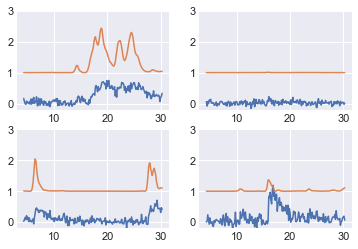

In [18]:
import seaborn as sns; sns.set()

plt.style.use('seaborn-darkgrid')
index = [127, 7, 777, 941]
time = np.arange(0,XX.shape[1])/sampling_rate

fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(time,XX[index[0],:,32]/100)
axs[0, 0].plot(time,Y_predict[index[0],:]/2+1)
axs[0, 0].set_ylim(-0.2, 3) 

axs[1, 0].plot(time,XX[index[1],:,32]/100)
axs[1, 0].plot(time,Y_predict[index[1],:]/2+1)
axs[1, 0].set_ylim(-0.2, 3) 

axs[0, 1].plot(time,XX[index[2],:,32]/100)
axs[0, 1].plot(time,Y_predict[index[2],:]/2+1)
axs[0, 1].set_ylim(-0.2, 3) 

axs[1, 1].plot(time,XX[index[3],:,32]/100)
axs[1, 1].plot(time,Y_predict[index[3],:]/2+1)
axs[1, 1].set_ylim(-0.2, 3) 



In [19]:
%matplotlib notebook

<IPython.core.display.Javascript object>


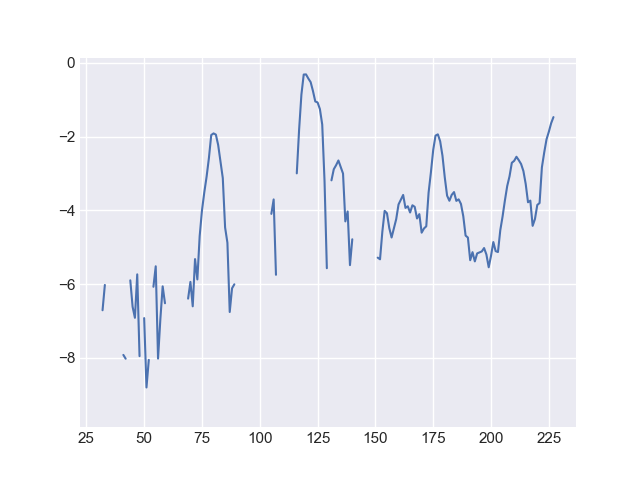

/home/adrian/anaconda3/envs/spiky/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


In [21]:
plt.figure()
plt.plot(np.log(Y_predict[index[3],:]))

### Fill up probabilities (output of the network) with discrete spikes

In [ ]:
# fileList is a list of mat-files with predictions
# fileList2 a list of mat-files with the corresponding calcium data
fileList = glob.glob( os.path.join( test_dataset_folder, 'Predictions','Predictions_*.mat'))
fileList2 = glob.glob( os.path.join( test_dataset_folder, 'Calcium*.mat'))

for file,file2 in zip(fileList,fileList2):

  prob_density_all = sio.loadmat(file)['Y_predict']
  calcium_all = sio.loadmat(file2)['dF_traces']
  
  # initialize resulting list of spikes / matrix of approximations
  # "approximations" show how well the inferred spikes match the input probabilities
  # they are generated by convolving each inferred spike with the Gaussian kernel that
  # was used for generating the ground truth
  
  spikes_all = []
  approximations_all = np.nan*np.ones(prob_density_all.shape)
  
  for neuron in range(prob_density_all.shape[0]):
    
    print('Infer spikes for neuron '+str(neuron+1)+' out of '+str(prob_density_all.shape[0])+' for file '+basename(file2))
    
    prob_density = prob_density_all[neuron,:]
    Calcium = calcium_all[:,neuron]/100
    
    spike_locs_all = []
    
    # find non-nan indices (first and last frames of predictions are NaNs)
    nnan_indices = ~np.isnan(prob_density)
    # offset in time to assign inferred spikes to correct positions in the end
    offset = np.argmax(nnan_indices==True) - 1
    
    if np.sum(nnan_indices) > 0:
    
      prob_density = prob_density[nnan_indices]
      Calcium = Calcium[nnan_indices]
      
      vector_of_indices = np.arange(0,len(prob_density))
      # "support_slices", indices of continuous chunks of the array which are non-zero and which might contain spikes
      support_slices = divide_and_conquer(prob_density,smoothing*sampling_rate)
      
      approximation = np.zeros(prob_density.shape)
      # go through each slice separately
      for k in range(len(support_slices)):
        
        spike_locs = []
        
        nb_spikes = np.sum(prob_density[support_slices[k]])
        
        # Monte Carlo/Metropolis-based sampling, initial guess of spikes
        spike_locs,approximation[support_slices[k]],counter = fill_up_APs(prob_density[support_slices[k]],smoothing*sampling_rate,nb_spikes,spike_locs)
        
        # every spike is shifted to any other position (no sub-pixel resolution) and the best position is used
        spike_locs,approximation[support_slices[k]] = systematic_exploration(prob_density[support_slices[k]],smoothing*sampling_rate,nb_spikes,spike_locs,approximation[support_slices[k]])

        # refine initial guess using random shifts or removal of spikes
        for jj in range(5):
          # remove the worst spikes
          spike_locs,approximation[support_slices[k]] = prune_APs(prob_density[support_slices[k]],smoothing*sampling_rate,nb_spikes,spike_locs,approximation[support_slices[k]])
          # fill up spikes again
          nb_spikes = np.sum(prob_density[support_slices[k]]) - np.sum(approximation[support_slices[k]])
          spike_locs,approximation[support_slices[k]],counter = fill_up_APs(prob_density[support_slices[k]],smoothing*sampling_rate,nb_spikes,spike_locs)
        
      
        temporal_offset = vector_of_indices[support_slices[k]][0]
        new_spikes = spike_locs+temporal_offset
        spike_locs_all.extend(new_spikes)
        
      approximations_all[neuron,nnan_indices] = approximation
      
    spikes_all.append(spike_locs_all+offset)
  
  # save results
  stripped_path = os.path.basename(os.path.normpath(file))
  sio.savemat(os.path.join(test_dataset_folder,'Predictions','Spikes_'+stripped_path),{'approximations_all':approximations_all,'spikes_all':spikes_all})



time = np.arange(0,len(prob_density_all[0,:]))/sampling_rate

index = [1,2,3,4]
index = [59, 7, 8, 57]
index = [11,12,13,14]
fig, axs = plt.subplots(2,2)
axs[0, 0].plot(time,prob_density_all[index[0],:]); axs[0, 0].plot(time,approximations_all[index[0],:]); axs[0, 0].set_ylim(-0.4, 3) 
axs[0, 0].plot(time,calcium_all[:,index[0]]/100+1.5); 
for spike in spikes_all[index[0]]:
  axs[0,0].plot([spike/sampling_rate,spike/sampling_rate],[-0.2, -0.1],'k')
axs[1, 0].plot(time,prob_density_all[index[1],:]); axs[1, 0].plot(time,approximations_all[index[1],:]); axs[1, 0].set_ylim(-0.4, 3) 
axs[1, 0].plot(time,calcium_all[:,index[1]]/100+1.5); 
for spike in spikes_all[index[1]]:
  axs[1,0].plot([spike/sampling_rate,spike/sampling_rate],[-0.2, -0.1],'k')
axs[0, 1].plot(time,prob_density_all[index[2],:]); axs[0, 1].plot(time,approximations_all[index[2],:]); axs[0, 1].set_ylim(-0.4, 3) 
axs[0, 1].plot(time,calcium_all[:,index[2]]/100+1.5); 
for spike in spikes_all[index[2]]:
  axs[0,1].plot([spike/sampling_rate,spike/sampling_rate],[-0.2, -0.1],'k')
axs[1, 1].plot(time,prob_density_all[index[3],:]); axs[1, 1].plot(time,approximations_all[index[3],:]); axs[1, 1].set_ylim(-0.4, 3) 
axs[1, 1].plot(time,calcium_all[:,index[3]]/100+1.5); 
for spike in spikes_all[index[3]]:
  axs[1,1].plot([spike/sampling_rate,spike/sampling_rate],[-0.2, -0.1],'k')

